### Subsetting ARCO Data from STAC assets

Note you should have first run search_edito_stac_zarr_assets.ipynb to get a list of ARCO (specifically Zarr) datasets (assets) that can be subsetted in this notebook.  In the example we will plot subsets of EMODnet Seabed Habitats data that has been converted into Zarr.  And a CMEMs Zarr dataset.  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import geopandas
import cartopy.crs as ccrs
import json
import ast
from copernicusmarine.core_functions import custom_open_zarr
from shapely.geometry import Point, box, Polygon, shape
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import time

In [2]:
assets_df = pd.read_csv('temperature_oxygen_habitat_arco_assets.csv')
assets_df

,Unnamed: 0,Collection ID,Item ID,Data Start,Data End,Bounds,Asset Key,Asset Href
0,0,climate_forecast-sea_water_potential_temperatu...,11b679c0-7053-5ec8-be04-48f68d594214,2005-01-01 00:00:00+00:00,2019-01-01T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[-180, 90...",omi-arco,https://s3.waw3-1.cloudferro.com/mdl-arco-time...
1,1,climate_forecast-sea_water_potential_temperatu...,11b679c0-7053-5ec8-be04-48f68d594214,2005-01-01 00:00:00+00:00,2019-01-01T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[-180, 90...",omi-arco-datalab-data-explorer,https://datalab.dive.edito.eu/data-explorer?so...
2,2,climate_forecast-sea_water_potential_temperatu...,9d3c0920-9bb7-507e-b673-c26d33b6f81e,2005-01-01 00:00:00+00:00,2019-01-01T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[-180, 90...",omi-arco,https://s3.waw3-1.cloudferro.com/mdl-arco-time...
3,3,climate_forecast-sea_water_potential_temperatu...,9d3c0920-9bb7-507e-b673-c26d33b6f81e,2005-01-01 00:00:00+00:00,2019-01-01T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[-180, 90...",omi-arco-datalab-data-explorer,https://datalab.dive.edito.eu/data-explorer?so...
4,4,climate_forecast-sea_water_potential_temperatu...,28d17777-1534-5021-ba2d-a98893c5b5b2,2005-01-01 00:00:00+00:00,2019-01-01T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[-180, 90...",omi-arco,https://s3.waw3-1.cloudferro.com/mdl-arco-time...
...,...,...,...,...,...,...,...,...
691,691,climate_forecast-sea_water_potential_temperatu...,b32219ec-435e-522a-9773-bd5225cc1d26,2025-01-25 01:00:00+00:00,2025-01-28T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[9.041582...",arco-time-series-datalab-data-explorer,https://datalab.dive.edito.eu/data-explorer?so...
692,692,climate_forecast-sea_water_potential_temperature,f137ea73-2bdb-51c1-aee7-c9b833cc37c2,2025-01-25 01:00:00+00:00,2025-01-28T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[9.041582...",arco-time-series,https://s3.waw3-1.cloudferro.com/mdl-arco-geo-...
693,693,climate_forecast-sea_water_potential_temperature,f137ea73-2bdb-51c1-aee7-c9b833cc37c2,2025-01-25 01:00:00+00:00,2025-01-28T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[9.041582...",arco-time-series-datalab-data-explorer,https://datalab.dive.edito.eu/data-explorer?so...
694,694,climate_forecast-sea_water_potential_temperature,23c1db4d-4266-568d-a6f7-ec4aafaaff89,2025-01-25 01:00:00+00:00,2025-01-28T00:00:00.000000Z,"{'type': 'Polygon', 'coordinates': [[[9.041582...",arco-geo-series,https://s3.waw3-1.cloudferro.com/mdl-arco-time...


### Subset Data
Now we can specifically find what kind of data we want. Dissolved oxygen, eunis_seabed_habitat_class, etc.  And with the link the the assets we can subset parts of large datasets.  

Find an array with sea water potential temperature over the atlantic ocean, between 2010 and 2020.  Any array with seabed habitats.  And Dissolved oxygen over the atlantic ocean, between 2010 and 2020.

In [3]:

# get assets that are in collections with 'seabed_habitat' in the name
seabed_habitat_assets = assets_df[assets_df['Collection ID'].str.contains('seabed_habitat')]

# filter by date
seabed_habitat_assets = seabed_habitat_assets[(seabed_habitat_assets['Data Start'] > '2000-01-01')]

# get just the asset urls
seabed_habitat_assets = seabed_habitat_assets['Asset Href']
if len(seabed_habitat_assets) > 0:
    # look for ARCO (Zarr) assets
    for url in seabed_habitat_assets:
        if '.zarr' in url and 's3' in url:
            seabed_habitat_asset = url
            break
else:
    print('No seabed habitat datasets found')

# open the dataset
habitat_ds = xr.open_dataset(seabed_habitat_asset, engine='zarr')

# list the variables
variables = list(habitat_ds.data_vars)
for idx, var in enumerate(variables):
    print(f"{idx}: {var}")

habitat_variable = 'eunis_seabed_habitat_class_2019'

# get the subset of the data just of that variable
habitat_subset = habitat_ds[habitat_variable]

# Get the geographic bounds in standard bbox format
habitat_bounds = [habitat_subset.longitude.values.min(), habitat_subset.latitude.values.min(), habitat_subset.longitude.values.max(), habitat_subset.latitude.values.max()]

print(habitat_subset)
print(habitat_bounds)


0: All2019D
1: All2019DL2
2: Allcomb
3: AllcombD
4: Biozone
5: EUNIS2019D
6: EUNIScomb
7: EUNIScombD
8: ModelCode
9: Oxygen
10: RegionalD
11: SalcombD
12: Salinity
13: Shape_Area
14: Shape_Length
15: Substrate
16: Val_comm
17: eunis_seabed_habitat_class_2019
18: marine_strategy_framework_directive_benthic_broad_habitat_type
19: seabed_energy
<xarray.DataArray 'eunis_seabed_habitat_class_2019' (latitude: 6004,
                                                     longitude: 7900)> Size: 190MB
[47431600 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 48kB 22.93 22.94 22.95 ... 82.94 82.95 82.96
  * longitude  (longitude) float64 63kB -36.0 -35.99 -35.98 ... 42.98 42.99 43.0
Attributes:
    _CRS:                  {'wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID...
    categorical_encoding:  {'MB11': 164, 'MB12': 26, 'MB13': 144, 'MB14': 105...
    geospatial_lat_max:    82.9644
    geospatial_lat_min:    22.9333
    geospatial_lon_max:    42.9996
    geospatial_

## Subsetting the Zarr datasets with Oxygen

We will then select the zarr datasets that are in the oxygen collection.  We will subset the STAC items based on their start time, end time, and their geographic boundaries.  To ensure the data assets in each item will be relevant for our seabed habitat boundaries and time extent. 

In [4]:

# Now lets get the dissolved oxygen data from 2010 to 2020

# find the dissolved oxygen collections, these have STAC items that have assets with oxygen data
oxygen_assets = assets_df[assets_df['Collection ID'].str.contains('oxygen')]

# filter the assets to only include data from 2010 to 2020
oxygen_assets = oxygen_assets[(oxygen_assets['Data Start'] > '2010-01-01') & (oxygen_assets['Data End'] >= '2020-12-31')]

# filter by habitat bounds
habitat_bounds_box = box(*habitat_bounds)

def convert_to_polygon(bounds):
    bounds = ast.literal_eval(bounds)
    coords = bounds.get('coordinates')
    
    try:
        # Flatten the list of lists
        flat_coords = [coord for sublist in coords for coord in sublist]
        # Extract longitudes and latitudes
        longitudes = [coord[0] for coord in flat_coords]
        latitudes = [coord[1] for coord in flat_coords]
        # Calculate the min and max values
        min_longitude = min(longitudes)
        max_longitude = max(longitudes)
        min_latitude = min(latitudes)
        max_latitude = max(latitudes)
        # Create the bounding box coordinates
        coords = [
            (min_longitude, min_latitude),
            (min_longitude, max_latitude),
            (max_longitude, max_latitude),
            (max_longitude, min_latitude),
            (min_longitude, min_latitude)  # Closing the polygon
        ]
        return Polygon(coords)
    except:
        return Polygon([(-180, -90), (-180, 90), (180, 90), (180, -90), (-180, -90)])


oxygen_assets['Bounds'] = oxygen_assets['Bounds'].apply(convert_to_polygon)

filtered_oxygen_assets = []
for index, row in oxygen_assets.iterrows():
    bounds = row['Bounds']
    
    if habitat_bounds_box.intersects(bounds):
        filtered_oxygen_assets.append(row)

# Convert the filtered list back to a DataFrame
filtered_oxygen_assets_df = pd.DataFrame(filtered_oxygen_assets)

filtered_oxygen_assets = filtered_oxygen_assets_df['Asset Href']

print(filtered_oxygen_assets)

140    https://s3.waw3-1.cloudferro.com/mdl-arco-time...
141    https://datalab.dive.edito.eu/data-explorer?so...
146    https://s3.waw3-1.cloudferro.com/mdl-arco-geo-...
147    https://datalab.dive.edito.eu/data-explorer?so...
148    https://s3.waw3-1.cloudferro.com/mdl-arco-time...
                             ...                        
677    https://datalab.dive.edito.eu/data-explorer?so...
678    https://s3.waw3-1.cloudferro.com/mdl-arco-geo-...
679    https://datalab.dive.edito.eu/data-explorer?so...
686    https://s3.waw3-1.cloudferro.com/mdl-arco-geo-...
687    https://datalab.dive.edito.eu/data-explorer?so...
Name: Asset Href, Length: 120, dtype: object


## Subsetting

Here is a general purpose subsetting function making use of xarray and copernicusmarine toolbox.  Adjust as needed for a given asset of interest, to select for different dimensions if elevation/depth/time are not needed.  The idea is to extract specific arrays of interest from these massive datasets, and use them for further analysis.

Be sure to select the correct variable from the dataset!  Some datasets can belong to multiple collections, because they contain multiple variables.  So choose your variable correctly.  Also select the data you need from a given dimension value (aka a certain time) or a certain elevation (or depth).  Or another dimension.  Augment the function to subset the data as necessary.

In [9]:
# open zarr dataset with xarray
def open_zarr(url):
    ds = xr.open_dataset(url, engine='zarr')
    return ds
# open zarr dataset with coperincusmarine
def open_custom_zarr(url):
    ds = custom_open_zarr.open_zarr(url)
    return ds

# subset a zarr dataset with user input
def subset_zarr_dataset_with_selection(ds, geographic_bounds=None):
    vars = list(ds.data_vars)
    dims = list(ds.dims)
    for idx, var in enumerate(vars):
        print(f"{idx}: {var}")
    time.sleep(1)
    # choose a variable
    input_var = input(f"Choose a variable by index (0-{len(vars)-1}) or enter -1 to skip this dataset: ")
    if input_var == '-1':
        return None
    print(f"Variable chosen: {vars[int(input_var)]}")
    variable = vars[int(input_var)]
    subset = ds[variable]

    # Find latitude and longitude dimensions
    lat_dim = next((dim for dim in dims if 'lat' in dim or dim == 'y'), None)
    lon_dim = next((dim for dim in dims if 'lon' in dim or dim == 'x'), None)

    if lat_dim and lon_dim:
        # subset the data to the geographic bounds
        subset = subset.sel({lon_dim: slice(ds[lon_dim][0], ds[lon_dim][-1]), lat_dim: slice(ds[lat_dim][0], ds[lat_dim][-1])})
        if geographic_bounds is not None:
            # Use geographic_bounds to subset the data
            subset = subset.sel({lon_dim: slice(geographic_bounds[0], geographic_bounds[2]), lat_dim: slice(geographic_bounds[1], geographic_bounds[3])})

    # begin with dimensions set to None
    input_time = None
    input_elevation = None
    input_depth = None

    # check for time, and ask user to choose an index in the time array
    if 'time' in dims:
        time_min = subset.time.min().values
        time_max = subset.time.max().values
        time_min_idx = subset.time.argmin().values
        time_max_idx = subset.time.argmax().values
        print(f"Time dimension found. Available time steps: {len(subset.time)}")
        print(f"Time range: {time_min} (index {time_min_idx}) to {time_max} (index {time_max_idx})")
        time.sleep(1)
        input_time = input(f"Choose a time step by index (0-{len(subset.time)-1}) or enter -1 to skip this dataset: ")
        if input_time == '-1':
            return None
        input_time = int(input_time)

    # check for elevation, and ask user to choose an index in the elevation array
    if 'elevation' in dims:
        elevation_min = subset.elevation.min().values
        elevation_max = subset.elevation.max().values
        elevation_min_idx = subset.elevation.argmin().values
        elevation_max_idx = subset.elevation.argmax().values
        print(f"Elevation dimension found. Available elevation steps: {len(subset.elevation)}")
        print(f"Elevation range: {elevation_min} (index {elevation_min_idx}) to {elevation_max} (index {elevation_max_idx})")
        time.sleep(1)
        input_elevation = input(f"Choose an elevation step by index (0-{len(subset.elevation)-1}) or enter -1 to skip this dataset: ")
        if input_elevation == '-1':
            return None
        input_elevation = int(input_elevation)

    # check for depth, and ask user to choose an index in the depth array
    if 'depth' in dims:
        depth_min = subset.depth.min().values
        depth_max = subset.depth.max().values
        depth_min_idx = subset.depth.argmin().values
        depth_max_idx = subset.depth.argmax().values
        print(f"Depth dimension found. Available depth steps: {len(subset.depth)}")
        print(f"Depth range: {depth_min} (index {depth_min_idx}) to {depth_max} (index {depth_max_idx})")
        time.sleep(1)
        input_depth = input(f"Choose a depth step by index (0-{len(subset.depth)-1}) or enter -1 to skip this dataset: ")
        if input_depth == '-1':
            return None
        input_depth = int(input_depth)

    # subset the data based on user input
    if input_time is not None and input_elevation is not None:
        array = subset.isel(time=input_time, elevation=input_elevation)
    elif input_time is not None and input_depth is not None:
        array = subset.isel(time=input_time, depth=input_depth)
    elif input_time is not None:
        array = subset.isel(time=input_time)
    else:
        array = subset

    return array



### Subsetting Oxygen Zarr datasets

Here we use the actual zarr datasets from the STAC items and subset a given dataset and extract a specific array.

In [10]:
oxygen_arrays = []
oxygen_datasets = []
if len(filtered_oxygen_assets) > 0:
    # look for ARCO (Zarr) assets
    for url in filtered_oxygen_assets:
        # zarr datasets from the datalab will not return data, and geoChunked datasets are not open for general use without copernicusmarine credentials
        if '.zarr' in url and 's3' in url and 'datalab' not in url and 'geoChunked' not in url:
            oxygen_datasets.append(url)
else:
    print('No oxygen datasets found')

for idx, url in enumerate(oxygen_datasets):
    print(f"{idx}: {url}")
    
input_url_idx = input(f"Choose a Zarr URL by index (0-{len(oxygen_datasets)-1}): ")
url = oxygen_datasets[int(input_url_idx)]

print(f'opening {url}')
ds = open_zarr(url)
oxygen_array = subset_zarr_dataset_with_selection(ds, habitat_bounds)
try:
    array = oxygen_array.values
    
except Exception as e:
    print(f"Error: {e}")
    array = None
if array is None:
    print('No data found for this dataset, trying custom open_zarr')
    ds = open_custom_zarr(url)
    oxygen_array = subset_zarr_dataset_with_selection(ds, habitat_bounds)
    try:
        array = oxygen_array.values
        
    except Exception as e:
        print(f"Error: {e}")
        array = None
            

0: https://s3.waw3-1.cloudferro.com/mdl-arco-time-001/arco/ARCTIC_ANALYSISFORECAST_BGC_002_004/cmems_mod_arc_bgc_anfc_ecosmo_P1M-m_202211/timeChunked.zarr
1: https://s3.waw3-1.cloudferro.com/mdl-arco-time-001/arco/ARCTIC_ANALYSISFORECAST_BGC_002_004/cmems_mod_arc_bgc_anfc_ecosmo_P1M-m_202211--ext--originalGrid/timeChunked.zarr
2: https://s3.waw3-1.cloudferro.com/mdl-arco-time-001/arco/ARCTIC_ANALYSISFORECAST_BGC_002_004/cmems_mod_arc_bgc_anfc_ecosmo_P1D-m_202105--ext--originalGrid/timeChunked.zarr
3: https://s3.waw3-1.cloudferro.com/mdl-arco-time-001/arco/ARCTIC_ANALYSISFORECAST_BGC_002_004/cmems_mod_arc_bgc_anfc_ecosmo_P1D-m_202105/timeChunked.zarr
4: https://s3.waw3-1.cloudferro.com/mdl-arco-time-034/arco/MEDSEA_MULTIYEAR_BGC_006_008/cmems_mod_med_bgc-bio_myint_4.2km_P1M-m_202112/timeChunked.zarr
5: https://s3.waw3-1.cloudferro.com/mdl-arco-time-006/arco/GLOBAL_ANALYSISFORECAST_BGC_001_028/cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m_202311/timeChunked.zarr
6: https://s3.waw3-1.cloudferr

### Plotting the seabed habitats data

Here we will first get the attribute encoding out of the seabed habitat zarr dataset.  The values in the variable (eunis_seabed_habitat_class_2019) from this zarr dataset are mapped to categorical values.  These values are found in the attributes of the variable in the dataset.   We can then do a reverse look up from the categorical encoding dictionary to get the string values, and use them in the legend of the plot.  For modelling these string values may not be necessary, they are not quantitative so should be set as categorical data in ML algorithms.

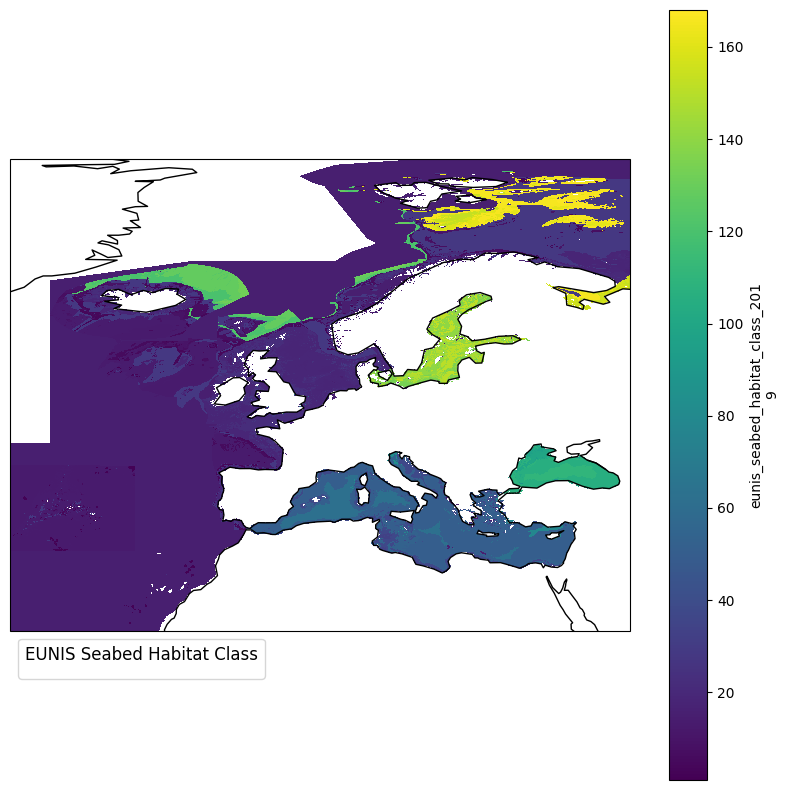

In [11]:

categorical_encoding = habitat_ds[habitat_variable].attrs['categorical_encoding']

# Function to decode categorical values
def categorical_decoding(value):
    for key, val in categorical_encoding.items():
        if val == value:
            return key
    return value

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Plot the data
habitat_subset.plot(ax=ax)

# Decode the categorical values for the legend
legend_labels = [categorical_decoding(val) for val in np.unique(habitat_subset.values)]

# Create a custom legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(0.0, 0.0), title='EUNIS Seabed Habitat Class', title_fontsize='large', fontsize='large')

# Show the plot
plt.show()

### Plotting the oxygen data

Here we plot the Oxygen data

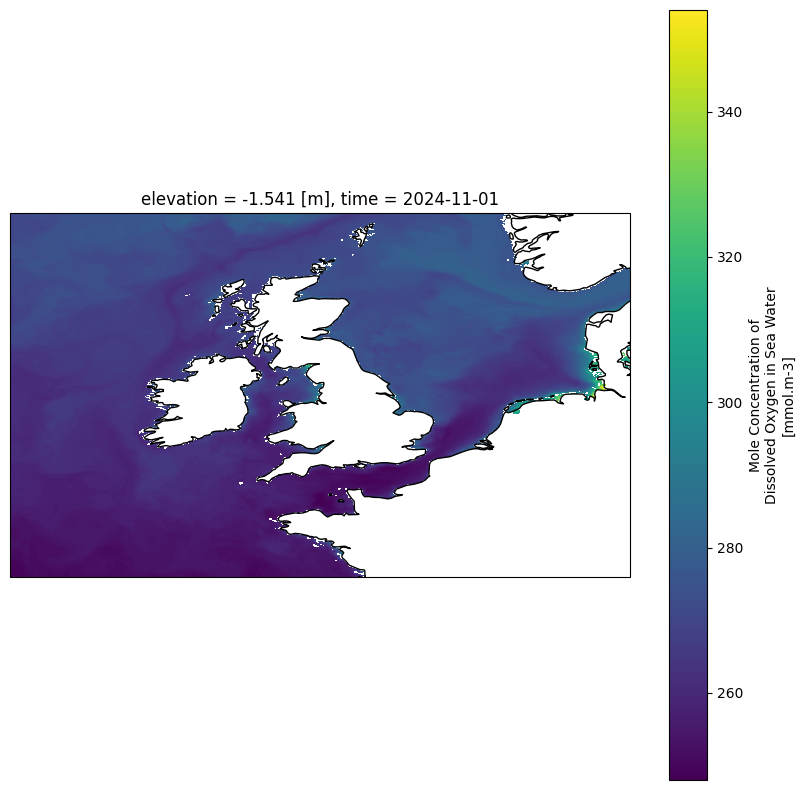

In [12]:
# Create the plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Plot the data
oxygen_array.plot(ax=ax)

# Show the plot
plt.show()